# Unidad Práctica 2: Visualización de Tablas

Por **Eduardo Graells-Garrido**. <egraells@udd.cl>. 

Actualizado: **17 de marzo de 2022**.

En esta práctica seguiremos trabajando con la Encuesta Origen-Destino de Santiago 2012. Exploraremos preguntas cuyas respuestas se obtienen utilizando técnicas de visualización de tablas.

## Google Colab

Para ejecutar este notebook en Colab, primero ejecuten la siguiente celda. Luego el notebook se reiniciará.

In [1]:
try:
    import google.colab
    !pip uninstall matplotlib -y
    !pip install -q condacolab
    
    import condacolab
    condacolab.install_mambaforge()
except ModuleNotFoundError:
    pass

Una vez que se ha reiniciado puedes ejecutar el resto de las celdas.

In [2]:
try:
    import google.colab
    !git clone https://github.com/zorzalerrante/aves.git aves_git
    !mamba env update --name base --file aves_git/environment-colab-light.yml
except ModuleNotFoundError:
    pass

## Preámbulo, Carga y Preparación de Datos

Esta celda configura la ruta a los datos. Asume dos alternativas: que usas Google Colab, o bien que ejecutas este notebook dentro de la carpeta del repositorio aves. 

In [3]:
import sys
from pathlib import Path

AVES_ROOT = Path("..") if not 'google.colab' in sys.modules else Path("aves_git")
EOD_PATH = AVES_ROOT /"data" / "external" / "EOD_STGO"
EOD_PATH

PosixPath('../data/external/EOD_STGO')

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

from aves.data import eod
from aves.features.utils import normalize_rows, normalize_columns

import matplotlib as mpl

# esto configura la calidad de la imagen. dependerá de tu resolución. el valor por omisión es 80
mpl.rcParams["figure.dpi"] = 96
# esto depende de las fuentes que tengas instaladas en el sistema.
mpl.rcParams["font.family"] = "Fira Sans Extra Condensed"


Leeremos la encuesta origen destino. Primero las personas. Le agregaremos dos atributos a la tabla:

* `Edad`: atributo cuantitativo definido como el año 2013 menos el año de nacimiento.
* `GrupoEtareo`: atributo ordinal definido como grupos de edad de 5 años. Se calcula a partir de `Edad` con la operación módulo.

In [5]:
personas = eod.read_people(EOD_PATH)

In [6]:
personas["Edad"] = 2013 - personas["AnoNac"]

personas["GrupoEtareo"] = personas["Edad"] - (personas["Edad"] % 5)
personas["GrupoEtareo"].value_counts()


20     5348
25     4571
15     4472
50     4248
40     4173
45     4008
30     4004
10     3898
35     3769
5      3694
55     3601
60     2998
0      2953
65     2775
70     2128
75     1423
80     1111
85      590
90      222
95       58
100       9
105       1
Name: GrupoEtareo, dtype: int64

Procedemos a leer las tablas restantes y a crear una tabla con toda la información.

In [7]:
hogares = eod.read_homes(EOD_PATH)

In [8]:
viajes = eod.read_trips(EOD_PATH)

In [9]:
tabla_completa = (viajes.merge(personas)).merge(hogares)


In [10]:
tabla_completa.sample(5)

,Hogar,Persona,Viaje,Etapas,ComunaOrigen,ComunaDestino,SectorOrigen,SectorDestino,ZonaOrigen,ZonaDestino,...,NumVeh,NumBicAdulto,NumBicNino,Propiedad,MontoDiv,ImputadoDiv,MontoArr,ImputadoArr,IngresoHogar,FactorHogar
85571,254372,25437203,2543720301,1,San Bernardo,San Bernardo,Sur,Sur,781,766,...,0,3,0,1,NaN,0,180000,0,417402,145.845749
60217,206850,20685001,2068500103,1,Pirque,Pirque,Sur-Oriente,Sur-Oriente,727,727,...,1,0,1,1,NaN,0,150000,0,776398,28.864252
26578,148990,14899004,1489900402,1,NaN,La Pintana,NaN,Sur,0,258,...,0,0,0,1,NaN,0,100000,0,590000,63.652515
5928,111261,11126101,1112610101,1,Conchalí,Independencia,Norte,Norte,89,166,...,1,0,0,3,NaN,0,150000,0,580000,164.385071
72035,228471,22847101,2284710101,2,Puente Alto,Puente Alto,Sur-Oriente,Sur-Oriente,692,692,...,0,1,0,2,70000.0,0,250000,0,412219,82.910416


En esta clase consideraremos los factores de expansión de la encuesta, que son necesarios para que los análisis sean representativos de la población.

El peso o representatividad de un viaje es la multiplicación de su factor de expansión (_qué tan frecuente ese tipo de viaje es_) y el del factor de expansión de cada persona (_qué tan representativa de otras personas es_). Además hay factores de expansión para días de semana, sábado, domingo, y periodos estival (vacaciones) y normal.

Trabajaremos con los periodos normales.

In [11]:
tabla_completa["PesoLaboral"] = (
    tabla_completa["FactorLaboralNormal"] * tabla_completa["FactorPersona"]
)

tabla_completa["PesoSabado"] = (
    tabla_completa["FactorSabadoNormal"] * tabla_completa["FactorPersona"]
)

tabla_completa["PesoDomingo"] = (
    tabla_completa["FactorDomingoNormal"] * tabla_completa["FactorPersona"]
)


## ¿Cuáles son las rutinas en la ciudad?

Para mejorar el funcionamiento de una ciudad es clave entender qué se hace en ella y cuándo.

Sabemos que el qué se hace está codificado en el atributo categórico `Proposito`. También sabemos que el atributo categórico `DiaAsig` se refiere al día que está asignado a la persona que responde la encuesta (al día de sus viajes).

In [12]:
tabla_completa["DiaAsig"]


0          jueves
1          jueves
2          jueves
3          jueves
4          jueves
           ...   
100329    domingo
100330    domingo
100331    domingo
100332    domingo
100333    domingo
Name: DiaAsig, Length: 100334, dtype: object

Definiremos una rutina como la distribución de viajes por tipo de propósito en cada unidad de análisis (en este caso, un día).

Utilizaremos operaciones `groupby` para calcular esa distribución para cada uno de los días de la semana, en periodo normal.

In [13]:
rutina_lunes_a_viernes = (
    tabla_completa[pd.notnull(tabla_completa["PesoLaboral"])]
    .groupby(["DiaAsig", "Proposito"])["PesoLaboral"]
    .sum()
    .unstack()
    .loc[["lunes", "martes", "miércoles", "jueves", "viernes"]]
)

rutina_lunes_a_viernes


Proposito,Al estudio,Al trabajo,Buscar o Dejar a alguien,Buscar o dejar algo,Comer o Tomar algo,De compras,De salud,Otra actividad (especifique),Por estudio,Por trabajo,Recreación,Trámites,Visitar a alguien,volver a casa
DiaAsig,,,,,,,,,,,,,,
lunes,163331.009416,290370.986587,71387.681371,7065.785357,11484.669371,84709.464346,34734.490540,24812.238886,17599.208422,35464.711518,22193.371789,58972.778600,24313.804430,7.122546e+05
martes,174439.776426,330180.424252,83276.907579,4720.350549,13277.306404,83855.135861,31484.930397,21999.526677,17947.370095,34045.254491,23936.417781,66379.161819,33555.124037,8.012940e+05
miércoles,199481.973499,398741.846543,86662.689333,8135.059386,19718.939423,130186.371335,54646.989179,30977.675729,18934.746992,62985.848813,23428.509000,75983.196793,53380.677754,9.866394e+05
jueves,182035.108396,349612.200228,106079.754074,6378.063755,10274.714329,118715.161069,40820.227170,21734.513481,15470.880297,42093.461466,29229.833235,70673.366141,44929.371294,8.802110e+05
viernes,223807.953547,400178.434211,105907.865006,8695.953519,16059.991523,147956.860167,40045.598930,37040.822368,22849.890914,50086.145707,62658.035583,93440.610247,66731.634748,1.046487e+06


In [14]:
rutina_sabado = (
    tabla_completa[pd.notnull(tabla_completa["PesoSabado"])]
    .groupby(["DiaAsig", "Proposito"])["PesoSabado"]
    .sum()
    .unstack()
)

rutina_domingo = (
    tabla_completa[pd.notnull(tabla_completa["PesoDomingo"])]
    .groupby(["DiaAsig", "Proposito"])["PesoDomingo"]
    .sum()
    .unstack()
)


Ahora uniremos estas tablas para tener una tabla única.

Además, eliminaremos los viajes de volver a casa y de tipo otra actividad porque no ayudan a caracterizar las rutinas diarias.

In [15]:
rutina_semanal = pd.concat(
    [rutina_lunes_a_viernes, rutina_sabado, rutina_domingo]
).drop(["volver a casa", "Otra actividad (especifique)"], axis=1)

rutina_semanal


Proposito,Al estudio,Al trabajo,Buscar o Dejar a alguien,Buscar o dejar algo,Comer o Tomar algo,De compras,De salud,Por estudio,Por trabajo,Recreación,Trámites,Visitar a alguien
DiaAsig,,,,,,,,,,,,
lunes,163331.009416,290370.986587,71387.681371,7065.785357,11484.669371,84709.464346,34734.490540,17599.208422,35464.711518,22193.371789,58972.778600,24313.804430
martes,174439.776426,330180.424252,83276.907579,4720.350549,13277.306404,83855.135861,31484.930397,17947.370095,34045.254491,23936.417781,66379.161819,33555.124037
miércoles,199481.973499,398741.846543,86662.689333,8135.059386,19718.939423,130186.371335,54646.989179,18934.746992,62985.848813,23428.509000,75983.196793,53380.677754
jueves,182035.108396,349612.200228,106079.754074,6378.063755,10274.714329,118715.161069,40820.227170,15470.880297,42093.461466,29229.833235,70673.366141,44929.371294
viernes,223807.953547,400178.434211,105907.865006,8695.953519,16059.991523,147956.860167,40045.598930,22849.890914,50086.145707,62658.035583,93440.610247,66731.634748
sábado,6632.211399,109218.910598,20016.534108,4518.136226,6519.612775,205890.072838,9716.742966,7007.223310,11250.685733,83467.604697,20536.963703,68399.114467
domingo,1382.036374,65413.281352,19317.983047,4856.792429,6858.284792,207106.972860,5123.241740,8066.969086,12798.502192,83617.829194,23863.931986,89631.140906


¿Cómo visualizar esta tabla? Una manera directa es utilizar el método `plot` de pandas, que usará un `linechart`. Veamos como luce:

<AxesSubplot:xlabel='DiaAsig'>

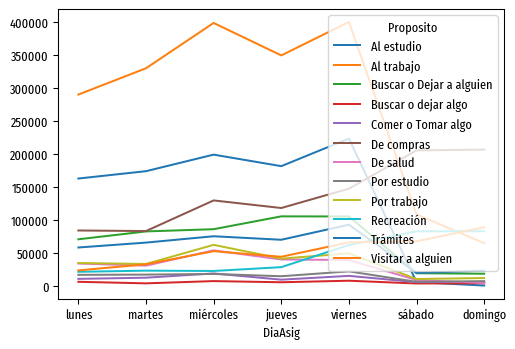

In [16]:
rutina_semanal.plot()


No se ve bonito, pero tampoco configuramos nada del gráfico, solamente lo ejecutamos para tener una noción de cómo se verían los datos. 

A pesar de que podríamos utilizar líneas, ya que la progresión de lunes a domingo es ordinal y puede ser interpolada, no tiene un significado relevante para nosotros de acuerdo a la definición de rutina. Además la cantidad de categorías en los datos hace difícil distinguir una línea de otra.

Podemos hacer la misma exploración, esta vez con un `barchart`:

<AxesSubplot:xlabel='DiaAsig'>

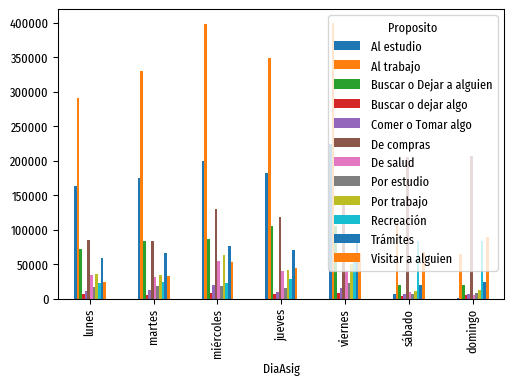

In [17]:
rutina_semanal.plot(kind="bar")


Esto ya parece ser más manejable para analizar. Utilicemos el `barchart` de aves para poder configurarlo fácilmente:

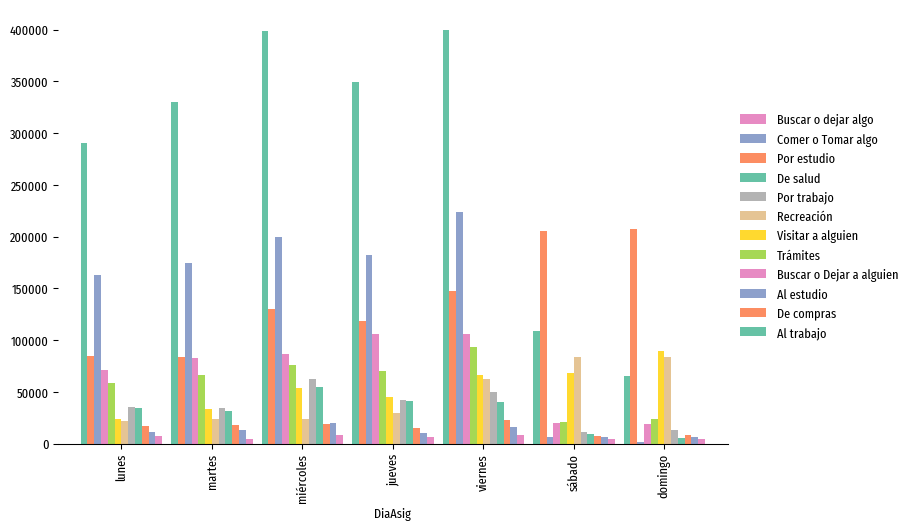

In [18]:
from aves.visualization.tables import barchart

fig, ax = plt.subplots(figsize=(9, 6))
barchart(ax, rutina_semanal, sort_categories=True, palette='Set2')


Seguimos teniendo muchas categorías, pero al menos podemos comparar sus distribuciones dentro de un día y ver algunos patrones globales, así como comparar la misma categoría a través de varios días.

**¿Qué ven ustedes en este gráfico?**

Una alternativa es usar una versión apilada, el `stacked barchart`:

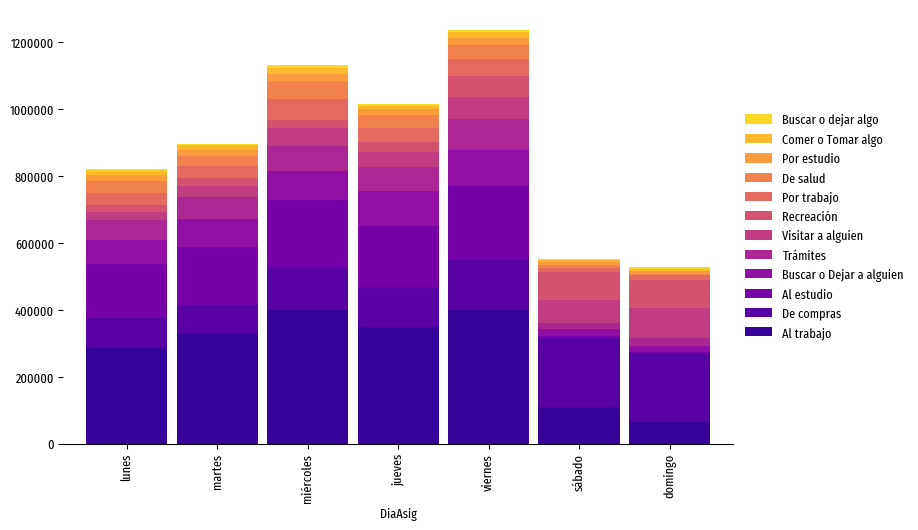

In [19]:
fig, ax = plt.subplots(figsize=(9, 6))
barchart(ax, rutina_semanal, stacked=True, sort_categories=True)


Este gráfico es similar al anterior, sin embargo, al ser apilado permite comparar fácilmente la categoría de base (_Al trabajo_). En las otras podemos identificar diferencias en aquellas que varían más (por ejemplo, _Al estudio_ y su diferencia entre lunes y viernes con el fin de semana), pero en general nos cuesta ver diferencias dentro de una misma categoría. 

Eso sumado a que las barras tienen largos totales diferentes, pues la cantidad de viajes dentro de cada día es distinta. Observamos que el fin de semana hay menos viajes.

Ahora bien, ¿nos interesa esa diferencia?¿O lo que buscamos es identificar patrones relativos? En tal caso, podemos probar con un gráfico normalizado:

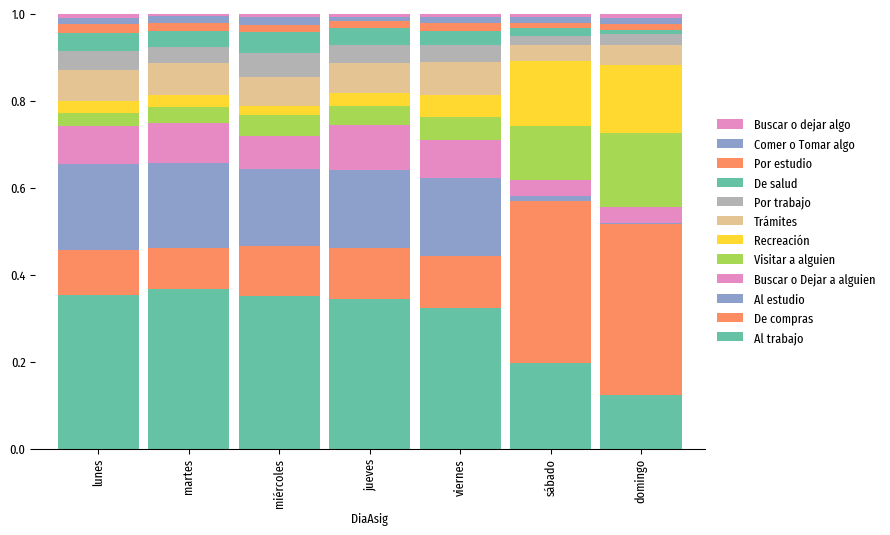

In [20]:
fig, ax = plt.subplots(figsize=(9, 6))
barchart(ax, rutina_semanal, stacked=True, normalize=True, sort_categories=True, palette='Set2')


Al usar un gráfico relativo encontramos diferencias que antes no parecían tan notorias. Por ejemplo, en proporción, los viajes de recreación son más frecuentes los fines de semana que de lunes a viernes. En el gráfico absoluto se notaba un ligero incremento, pero quizás lo interesante es que, así como suben los de recreación, bajan mucho los demás. 

Lo mismo sucede con visitar a alguien e ir de compras.

El gráfico de barras podría ser suficiente si lo que queremos es determinar si hay diferencias entre las rutinas. Con esta última versión, sabemos que son diferentes, y tenemos una noción de cuáles son las diferencias.

Sin embargo, si nuestra tarea consistiese en identificar elementos específicos de las rutinas, como puede ser _conocer los valores exactos de la distribución_, o _agrupar actividades de acuerdo a su distribución en varios días_, entonces debemos buscar otra alternativa.

Exploremos como luce un heatmap en este caso:

<AxesSubplot:xlabel='Proposito', ylabel='DiaAsig'>

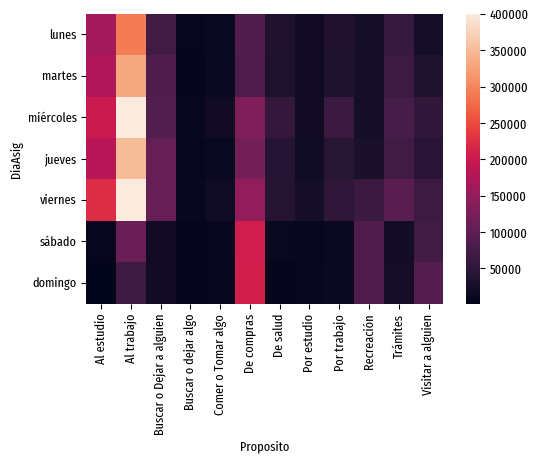

In [21]:
import seaborn as sns

sns.heatmap(rutina_semanal)


Lo que hicimos en el gráfico de barras fue normalizar las columnas de la tabla. Podemos hacer lo mismo. Y luego trasponerla para facilitar la lectura. Quedaría así:

<AxesSubplot:xlabel='DiaAsig', ylabel='Proposito'>

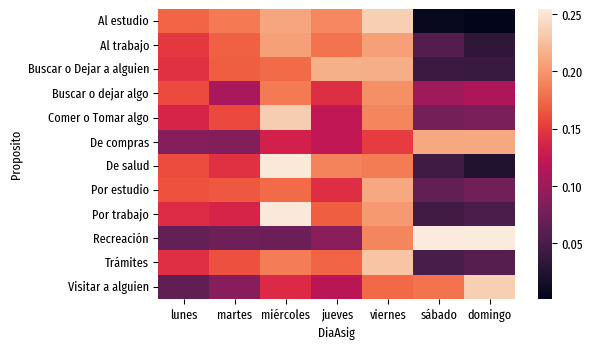

In [22]:
sns.heatmap(rutina_semanal.pipe(normalize_columns).T)


Observamos que este heatmap nos permite apreciar las variaciones diarias en la proporción. Si lo configuramos para que muestre más información y tenga mejor apariencia podría ser el gráfico final de la tarea:

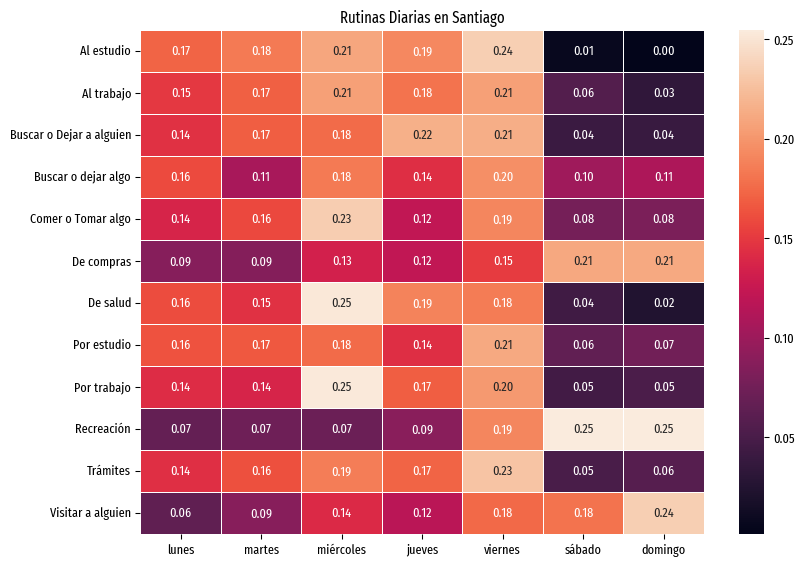

In [23]:
fig, ax = plt.subplots(figsize=(9, 6))

sns.heatmap(
    rutina_semanal.pipe(normalize_columns).T,
    ax=ax,
    annot=True,
    fmt=".2f",
    linewidth=0.5,
)

ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title("Rutinas Diarias en Santiago")

fig.tight_layout()


Ese gráfico ya está terminado: podemos ver patrones globales gracias a la escala de colores, y podemos comparar e identificar valores específicos gracias a las anotaciones.

Todavía nos falta poder agrupar las actividades (o filas de la matriz) de acuerdo a su similitud. Afortunadamente lo podemos lograr cambiando el método empleado: usar un `clustermap` en vez de un `heatmap`:

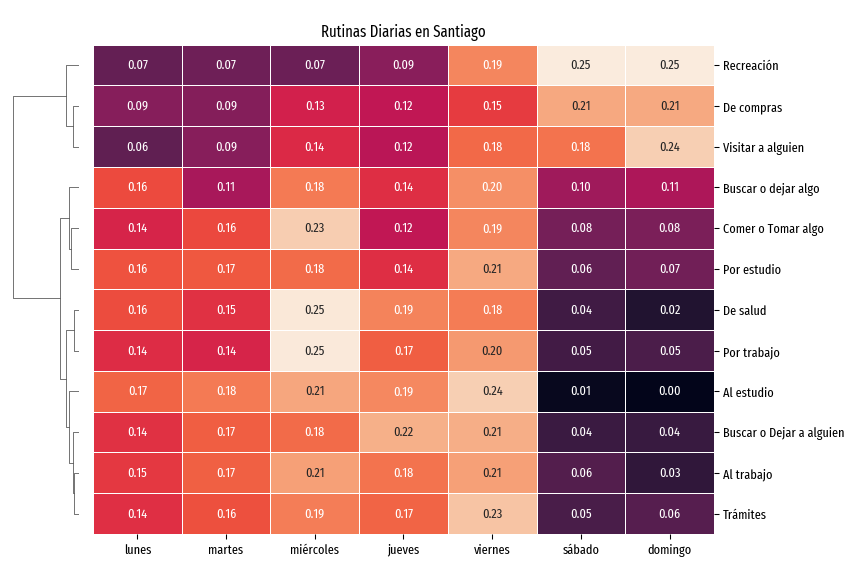

In [24]:
grid = sns.clustermap(
    rutina_semanal.pipe(normalize_columns).T,
    col_cluster=False,
    figsize=(9, 6),
    annot=True,
    fmt=".2f",
    linewidth=0.5,
    dendrogram_ratio=[0.1, 0.0],
    method="ward"
)

grid.ax_cbar.set_visible(False)
grid.ax_heatmap

grid.ax_heatmap.set_ylabel("")
grid.ax_heatmap.set_xlabel("")
grid.ax_heatmap.set_title("Rutinas Diarias en Santiago")

grid.fig.tight_layout()


Con esto ya damos por resuelta la tarea de entender las rutinas diarias. 

Los siguientes son **ejercicios propuestos**:

- Realizar el mismo cálculo para período estival (requiere calcular los factores de expansión correspondientes).
- Realizar el mismo cálculo para hombres y mujeres por separado.
- Visualizar las diferentes por género y por temporada.

## ¿Cuáles son los perfiles etáreos asociados a las actividades?

Hemos analizado las rutinas diarias, sin embargo, no podemos asumir que todas las personas hacen lo mismo. Una de las dimensiones que podría presentar las diferencias más grandes en la configuración de las rutinas es la edad.

En esta tarea queremos saber si hay tendencias en como distintas edades realizan las actividades que hemos estudiado.

Lo primero que podemos hacer es calcular la tabla de asociación utilizando una operación `groupby`:

In [25]:
rutina_x_edad = (
    tabla_completa.groupby(["GrupoEtareo", "Proposito"])["PesoLaboral"].sum().unstack()
)

rutina_x_edad


Proposito,Al estudio,Al trabajo,Buscar o Dejar a alguien,Buscar o dejar algo,Comer o Tomar algo,De compras,De salud,Otra actividad (especifique),Por estudio,Por trabajo,Recreación,Trámites,Visitar a alguien,volver a casa
GrupoEtareo,,,,,,,,,,,,,,
0,42845.641137,447.418443,17278.201471,458.819947,25.105106,18021.787343,11745.021804,6494.619821,4909.880583,NaN,6683.626741,6922.065900,13443.436222,127572.411334
5,211666.192896,638.584542,6424.147522,618.402344,259.629435,10380.601513,5025.680469,3428.100560,15179.304869,NaN,9714.993789,1696.103686,10173.413551,283033.860317
10,219341.643192,439.525230,10746.005365,490.339247,794.708341,8626.747498,2056.097014,2560.097311,16785.791015,65.873625,8700.525588,1422.775574,8773.531463,290355.264648
15,222903.900288,20173.788948,7588.091555,1171.162756,2096.077577,7776.439153,6448.131871,3280.679239,22004.711692,3231.361837,16276.490178,7926.085263,15343.624558,330047.529212
20,153552.228086,135644.859121,17073.170904,685.423940,4487.416453,25883.510725,6829.349509,8350.148845,16643.054401,7246.049615,15953.114544,18850.959560,24245.331966,382677.399577
25,60258.937374,220915.626067,36423.248726,1082.937472,9508.900863,37562.197060,10261.148343,11732.586970,11911.965536,14141.970709,23361.725470,17648.072290,30050.137867,399741.751710
30,14962.215173,223509.770478,45506.731650,5076.295884,12571.781491,33163.793721,8929.908849,12325.231355,2645.097389,30208.079124,13830.832589,22034.258364,19725.207622,351676.333985
35,9518.445119,219291.908633,63497.909600,2223.361356,9584.806085,40365.785714,13487.509767,9979.645370,437.188201,27798.977683,11848.925609,25060.628078,11019.842816,353796.986308
40,2251.234733,213048.059813,75690.394083,2624.825189,5945.397855,42627.295039,9200.755339,8194.053095,764.252183,18811.466341,8467.104393,41123.310213,7381.595282,335004.645585


Tenemos como índice de la tabla un valor cuantitativo y queremos ver las tendencias de cada atributo cuantitativo. Podemos utilizar un `linechart` para ello. Como sabemos que son muchas actividades, esta vez configuraremos el gráfico de inmediato para que luzca bien: graficaremos cada actividad por separado utilizando la configuración de los subgráficos (`subplots`).

Este código requiere entender aspectos más avanzados de matplotlib:

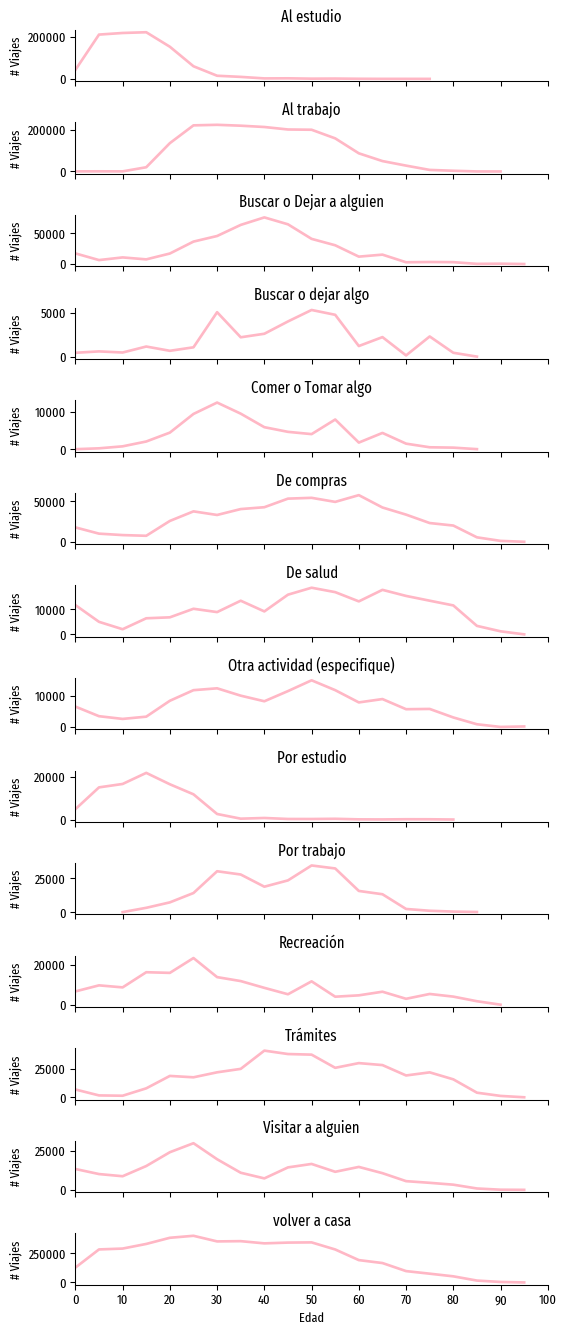

In [26]:
fig_ancho = 6
fig_alto = 1

fig, axes = plt.subplots(
    len(rutina_x_edad.columns),
    1,
    figsize=(fig_ancho, len(rutina_x_edad.columns) * fig_alto),
    sharex=True,
)

for col, ax in zip(rutina_x_edad.columns, axes):
    rutina_x_edad[col].plot(ax=ax, kind="line", color="#FFB7C5", linewidth=2)
    ax.set_title(col)
    sns.despine(ax=ax)
    ax.set_xlim([0, 100])
    ax.set_xticks(range(0, 101, 10))
    ax.set_xlabel("Edad")
    ax.set_ylabel("# Viajes")

fig.align_ylabels()
fig.tight_layout()


Observamos que con esta configuración es directo saber para cada actividad cuál es su asociación con cada grupo etáreo. También sabemos cuando hay tendencias de subida o de bajada. Es un gráfico directo de hacer que nos permite analizar cada actividad por separado, pero también comparar entre ellas, ya que comparten el mismo eje x de referencia.

Ahora bien, nos preocupa que el código se complejiza al configurarlo. 

Podemos utilizar seaborn para configurar de manera más sencilla y flexible el gráfico. Por ejemplo, podemos configurarlo para que utilice dos columnas de gráficos en vez de solo una. Eso también lo podemos hacer con el código anterior, pero el cambio en el código escrito sería considerable y requiere conocer parte del funcionamiento interno de matplotlib.

Antes de hacerlo necesitamos convertir la tabla que tiene forma de matriz a una tabla en formato "largo", ya que las funciones de grilla de seaborn utilizan este formato. Se hace así:

In [27]:
rutina_x_edad_longform = rutina_x_edad.stack().rename("n_viajes").reset_index()
rutina_x_edad_longform.sample(5)

,GrupoEtareo,Proposito,n_viajes
216,75,Por estudio,157.556950
6,0,De salud,11745.021804
239,85,De compras,5878.449598
190,65,Recreación,6535.517782
54,20,Al estudio,153552.228086


Noten que la diferencia es que cada fila de la tabla contiene un par edad/propósito y el valor correspondiente. Es como si cada celda de la matriz original tuviese su propia fila.

El código de seaborn:

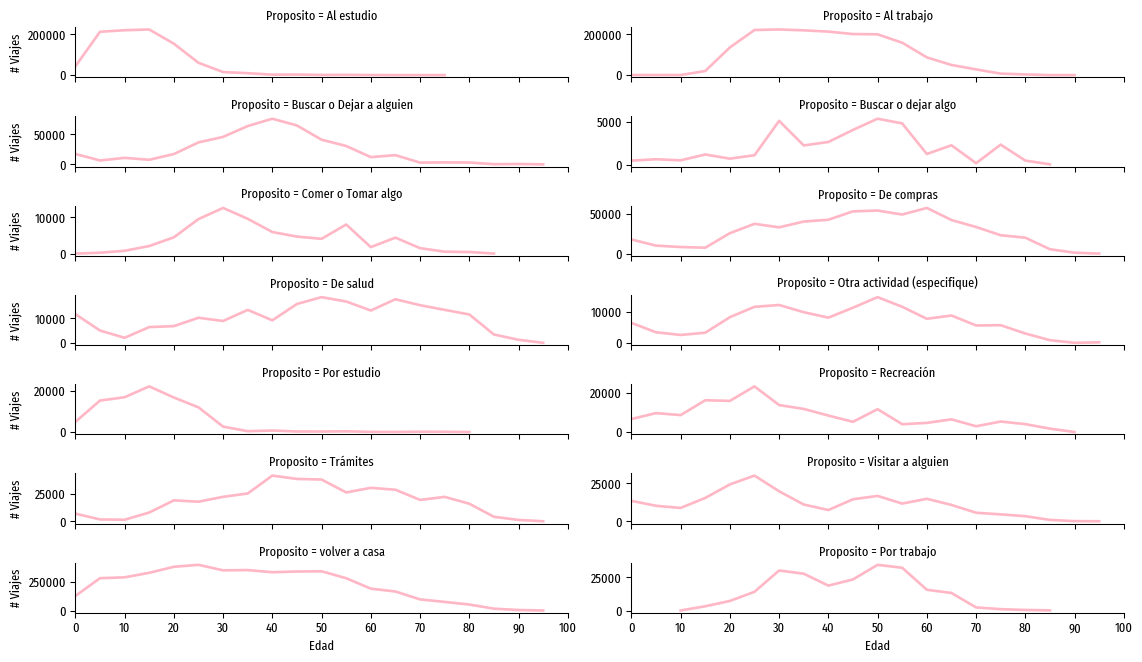

In [28]:
grid = sns.FacetGrid(
    rutina_x_edad_longform,
    col="Proposito",
    col_wrap=2,
    aspect=6,
    height=1,
    sharey=False,
)

grid.map(plt.plot, "GrupoEtareo", "n_viajes", color="#FFB7C5", linewidth=2)

sns.despine()
grid.set(xlim=[0, 100])
grid.set_xlabels("Edad")
grid.set_ylabels("# Viajes")
grid.set(xticks=range(0, 101, 10))
grid.fig.align_ylabels()
grid.tight_layout()


Observando este gráfico notamos cosas como:

- El aumento de los viajes de salud con la edad hasta los 65 años. Después comienzan a disminuir (recordemos que estamos midiendo viajes absolutos).
- La mayor cantidad de personas que sale a comer o tomar algo tiene 30 años.
- Los viajes de buscar o dejar a alguien alcanzan su valor máximo a los 40 años y luego decaen. Posiblemente a los 40 les hijes ya están grandecites para que los vayan a dejar a algún lado.
- **¿Qué más observan ustedes?**

Calculemos la versión normalizada por edad. Recordemos que en la tarea anterior normalizamos la matriz por columnas, porque nos interesaba la distribución de días por actividad. Ahora nos interesa la distribución de actividades por edad, por tanto, normalizaremos por filas. El código para la visualización es el mismo excepto por el parámetro de datos de `FacetGrid` (esta vez la transformación a tabla larga la hacemos en la misma línea de código):

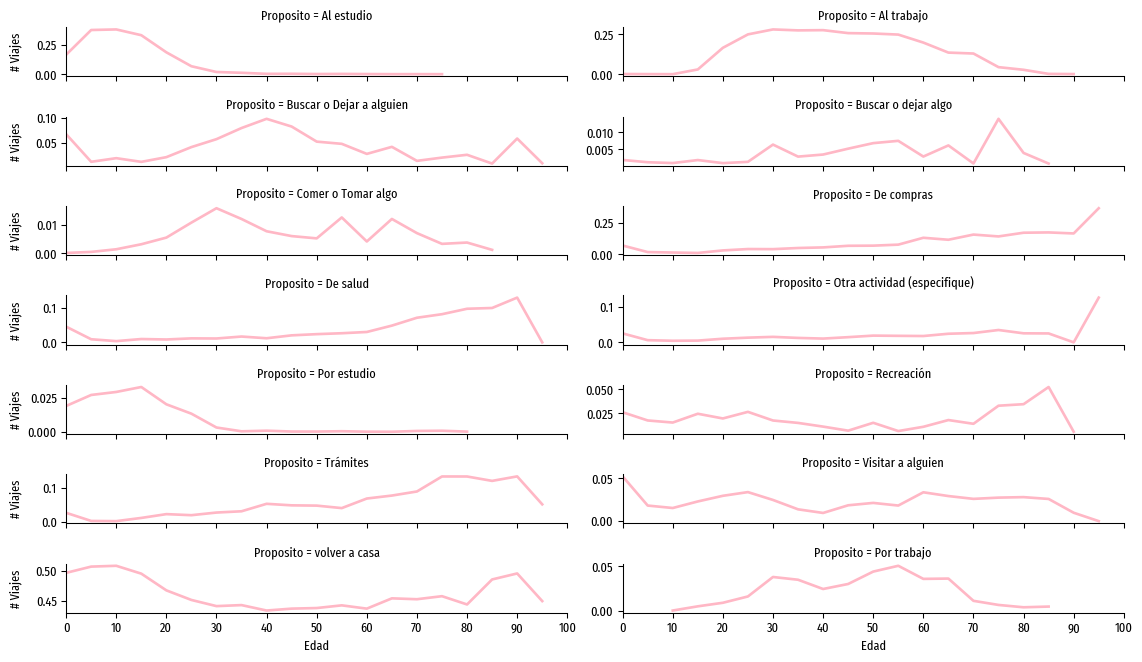

In [29]:
grid = sns.FacetGrid(
     rutina_x_edad.pipe(normalize_rows).stack().rename("n_viajes").reset_index(),
    col="Proposito",
    col_wrap=2,
    aspect=6,
    height=1,
    sharey=False,
)

grid.map(plt.plot, "GrupoEtareo", "n_viajes", color="#FFB7C5", linewidth=2)

sns.despine()
grid.set(xlim=[0, 100])
grid.set_xlabels("Edad")
grid.set_ylabels("# Viajes")
grid.set(xticks=range(0, 101, 10))
grid.fig.align_ylabels()
grid.tight_layout()

En este gráfico observamos que algunos patrones absolutos se mantienen (como las distribuciones de _al estudio_ y _al trabajo_), pero otros patrones adquieren una forma más ad-hoc a nuestras expectativas. Por ejemplo, los viajes _de salud_ aumentan progresivamente con la edad. Solamente caen en el último grupo etáreo, sin embargo, la cantidad de viajes de ese grupo es tan pequeña que no podemos sacar conclusiones.

**¿Qué otros patrones ven ustedes?**

Problema propuesto:

- Estudiar el uso de modo de transporte (columna `ModoDifusion`) por grupo etáreo.

## ¿Cuál es la distribución de distancias recorridas?

La última tarea de este notebook busca comprender las diferencias en las distribuciones de las distancias recorridas en los viajes al trabajo. Si consideramos la ubicación de los sectores laborales en Santiago, las personas de sectores más periféricos de la ciudad recorran distancias más grandes que la gente que vive, por ejemplo, en el centro. Pero no toda la población trabaja en esos ejes laborales. Por tanto, es de interés conocer la distribución de las distancias recorridas.

La encuesta incluye la variable `DistManhattan` que representa la distancia recorrida a través de dos líneas en un viaje, una horizontal y una vertical. Veamos su estadística descriptiva:

In [30]:
tabla_completa['DistManhattan'].describe().astype(int)

count     100334
mean        8034
std        16064
min           -1
25%         1110
50%         4054
75%        11038
max      1413673
Name: DistManhattan, dtype: int64

De partida observamos que hay valores inválidos (distancias con valor -1) y también valores que se salen de lo común (1400 kilómetros). Los propósitos de esos viajes son los siguientes:

In [31]:
tabla_completa[tabla_completa['DistManhattan'] < 0][['Proposito', 'ComunaOrigen', 'ComunaDestino', 'ModoDifusion']].sample(10)

,Proposito,ComunaOrigen,ComunaDestino,ModoDifusion
99796,volver a casa,Colina,Colina,Caminata
73144,volver a casa,Puente Alto,Puente Alto,Caminata
99779,volver a casa,Colina,Colina,Caminata
663,De compras,Buin,Buin,Caminata
55818,De compras,Pedro Aguirre Cerda,Pedro Aguirre Cerda,Caminata
33525,volver a casa,NaN,Las Condes,Auto
25270,De compras,La Pintana,La Pintana,Caminata
14789,Al trabajo,Isla de Maipo,NaN,Auto
22081,volver a casa,La Granja,La Granja,Caminata
37665,Al trabajo,Lo Espejo,Lo Espejo,Caminata


In [32]:
tabla_completa[tabla_completa['DistManhattan'] > 1000000][['Proposito', 'ComunaOrigen', 'ComunaDestino', 'SectorDestino', 'ModoDifusion']]

,Proposito,ComunaOrigen,ComunaDestino,SectorDestino,ModoDifusion
4825,Otra actividad (especifique),Estación Central,NaN,Exterior a RM,Otros
87077,Al trabajo,San Bernardo,NaN,Exterior a RM,Otros
91669,Al trabajo,San Ramón,NaN,Exterior a RM,Bip! - Otros Público


Notamos que los viajes con distancia muy grande pueden ser válidos. Por ejemplo, es gente que tuvo que hacer un viaje a su trabajo fuera de Santiago y viajaron en avión.

Los viajes con distancia -1 parecieran ser principalmente dentro de la misma comuna y en modos de transporte privado. Debido a su valor negativo es mejor descartarlos de la muestra.

Para entender las distribuciones utilizaremos un `boxplot`. Como vimos en clase, este tipo de gráfico utiliza percentiles y medianas, por lo que los valores extremos de la distribución no tienen una influencia relevante en el resultado (tres valores extremos de distancia no cambiarán la mediana).

Utilizaremos el `boxplot` de aves porque permite considerar el factor de expansión. Primero, veamos las distribuciones de acuerdo al sector de la ciudad donde viven las personas. Al ser pocas categorías nos permitirán entender como funciona la técnica:

In [33]:
from aves.visualization.tables.boxplot import boxplot

In [34]:
tabla_filtrada = tabla_completa[(tabla_completa['DistManhattan'] > 0) & (tabla_completa['Proposito'] == 'Al trabajo')]

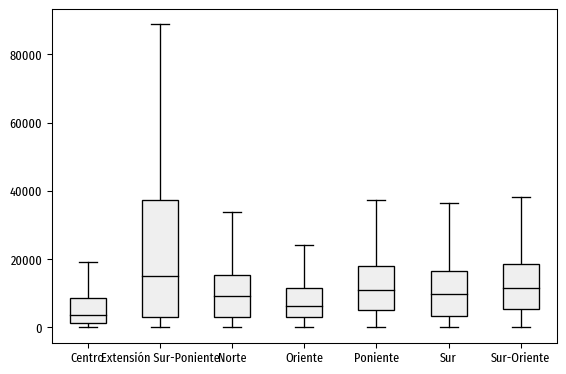

In [35]:
fig, ax = plt.subplots()

boxplot(
    ax,
    tabla_filtrada,
    "Sector", # atributo categórico que compararemos
    "DistManhattan", # atributo cuantitativo
    "PesoLaboral" # factor de expansión
)

fig.tight_layout()

Podemos configurar la apariencia del gráfico para que sea más fácil de leer:

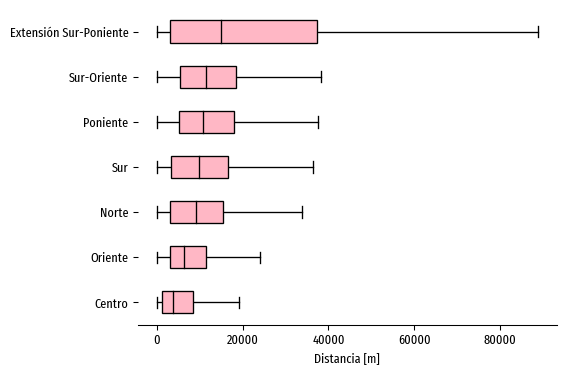

In [36]:
fig, ax = plt.subplots()

boxplot(
    ax,
    tabla_filtrada,
    "Sector",
    "DistManhattan",
    "PesoLaboral",
    vert=False,
    sort_by_value=True,
    showfliers=False,
    boxplot_kwargs=dict(boxprops={"facecolor": "#FFB7C5"}),
)

sns.despine(ax=ax, left=True)
ax.set_xlabel("Distancia [m]")
fig.tight_layout()


Observamos que:

- El sector centro tiene la menor mediana y el menor percentil del 75%. Es el sector con menor variabilidad.
- El sector oriente es el segundo en cercanía al trabajo y en menor variabilidad.
- El sector con mayor variabilidad y mayores distancias es externo al radio urbano.

Ahora veamos las diferencias de acuerdo al modo de transporte utilizado:

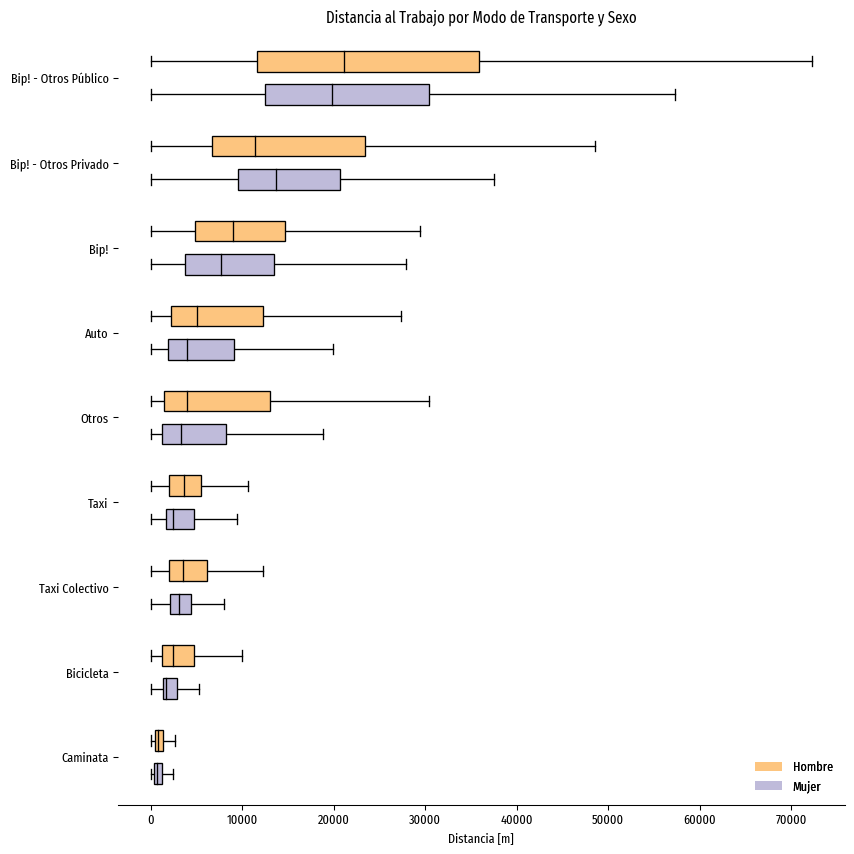

In [37]:
fig, ax = plt.subplots(figsize=(9, 9))

boxplot(
    ax,
    tabla_completa,
    "ModoDifusion",
    "DistManhattan",
    "PesoLaboral",
    hue_column="Sexo",
    hue_legend=True,
    vert=False,
    sort_by_value=True,
    palette="PuOr",
    showfliers=False,
)

sns.despine(ax=ax, left=True)
ax.set_xlabel("Distancia [m]")
ax.set_title("Distancia al Trabajo por Modo de Transporte y Sexo")
fig.tight_layout()


Observamos lo siguiente:

- En general, las mujeres recorren una distancia menor en sus viajes al trabajo, en casi todo modo de transporte (o combinación de modos). Existen varias explicaciones para esto, una de ellas es que necesitan recorrer menos distancia porque deben cumplir roles en el hogar que los hombres no asumen.
- Los viajes en transporte público son más largos que los viajes en auto. 
- Hay viajes en bicicleta que son más largos que viajes en auto. Si queremos descontaminar la ciudad una manera de hacerlo es incentivar que viajes cortos en auto se hagan en modos alternativos.

**¿Qué ven ustedes?**

Problema **propuestos**:

- Realizar un ejercicio similar para los tiempos de viaje. Motivación: un viaje en auto y un viaje en transporte público pueden tener tiempos muy distintos a pesar de cubrir la misma distancia.